In [71]:
import pandas as pd
import time
import praw
import numpy
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt  
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [88]:
'''SET UP'''

#Getting Previous 100 TWABs
url = "https://api.pushshift.io/reddit/search/submission/?subreddit=DestinyTheGame&title=%22This%20Week%20At%20Bungie%22&author=DTG_Bot&selftext:not&sort=created_utc:desc&limit=1000"
TWABs = requests.get(url) 
data = TWABs.json()

#saving to file
with open('data.json', 'w') as f:
    json.dump(data, f)

# load data using Python JSON module
with open('data.json','r') as f:
    data = json.loads(f.read())
    
# Flatten data
df_nested_list = pd.json_normalize(data, record_path =['data'])
IDs = df_nested_list[["id"]]
ids = pd.read_csv('ids.csv')

#merge with older IDs
ids = pd.concat([IDs,ids]).drop_duplicates().reset_index(drop=True)

#connecting to praw reddit api
REDDIT = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='')

SUBREDDIT = REDDIT.subreddit('DestinyTheGame')

dfSub= pd.DataFrame()

x = 0
while x <len(ids):
    submission = REDDIT.submission(id=ids["id"][x])
    dfSub.at[x,"Title"] = submission.title
    dfSub.at[x,"Date"] = datetime.fromtimestamp(submission.created_utc)
    dfSub.at[x,"Score"] = submission.score
    dfSub.at[x,"UpvoteRatio"] = submission.upvote_ratio
    dfSub.at[x,"Comments"] = submission.num_comments
    dfSub.at[x,"Url"] = submission.url
    x +=1

#save to csv
dfSub.to_csv('historical.csv',index=None)

In [89]:
#Loading data from csv
dfSub= pd.read_csv('historical.csv')
dfSub['Date'] = pd.to_datetime(dfSub['Date'])
dfSub = dfSub.sort_values(by='Date')
dfSub = dfSub.reset_index(drop = True)
dfSub['5week_rolling_avg'] = dfSub.UpvoteRatio.rolling(5, center=False,min_periods=3).mean()

In [90]:
# Expansions
dfSub.loc[dfSub['Date'] > datetime.strptime('9-7-2017', '%m-%d-%Y'), 'Expansion'] = "Vanilla"
dfSub.loc[dfSub['Date'] > datetime.strptime('9-4-2018', '%m-%d-%Y'), 'Expansion'] = "Forsaken"
dfSub.loc[dfSub['Date'] > datetime.strptime('10-1-2019', '%m-%d-%Y'), 'Expansion'] = "Shadowkeep"
dfSub.loc[dfSub['Date'] > datetime.strptime('11-10-2020', '%m-%d-%Y'), 'Expansion'] = "BeyondLight"

#Seasons
dfSub.loc[dfSub['Date'] < datetime.strptime('12-4-2018', '%m-%d-%Y'), 'Season'] = "Red War"
dfSub.loc[dfSub['Date'] > datetime.strptime('12-5-2017', '%m-%d-%Y'), 'Season'] = "Curse of Osiris"
dfSub.loc[dfSub['Date'] > datetime.strptime('5-8-2018', '%m-%d-%Y'), 'Season'] = "Warmind"
dfSub.loc[dfSub['Date'] > datetime.strptime('9-4-2018', '%m-%d-%Y'), 'Season'] = "Season of the Outlaw"
dfSub.loc[dfSub['Date'] > datetime.strptime('12-4-2018', '%m-%d-%Y'), 'Season'] = "Season of the Forge"
dfSub.loc[dfSub['Date'] > datetime.strptime('3-5-2019', '%m-%d-%Y'), 'Season'] = "Season of the Drifter"
dfSub.loc[dfSub['Date'] > datetime.strptime('6-6-2019', '%m-%d-%Y'), 'Season'] = "Season of Opulence"
dfSub.loc[dfSub['Date'] > datetime.strptime('10-1-2019', '%m-%d-%Y'), 'Season'] = "Season of the Undying"
dfSub.loc[dfSub['Date'] > datetime.strptime('12-10-2019', '%m-%d-%Y'), 'Season'] = "Season of Dawn"
dfSub.loc[dfSub['Date'] > datetime.strptime('3-10-2020', '%m-%d-%Y'), 'Season'] = "Season of the Worthy"
dfSub.loc[dfSub['Date'] > datetime.strptime('6-9-2020', '%m-%d-%Y'), 'Season'] = "Season of Arrivals"
dfSub.loc[dfSub['Date'] > datetime.strptime('11-10-2020', '%m-%d-%Y'), 'Season'] = "Season of the Hunt"
dfSub.loc[dfSub['Date'] > datetime.strptime('2-9-2021', '%m-%d-%Y'), 'Season'] = "Season of the Chosen"

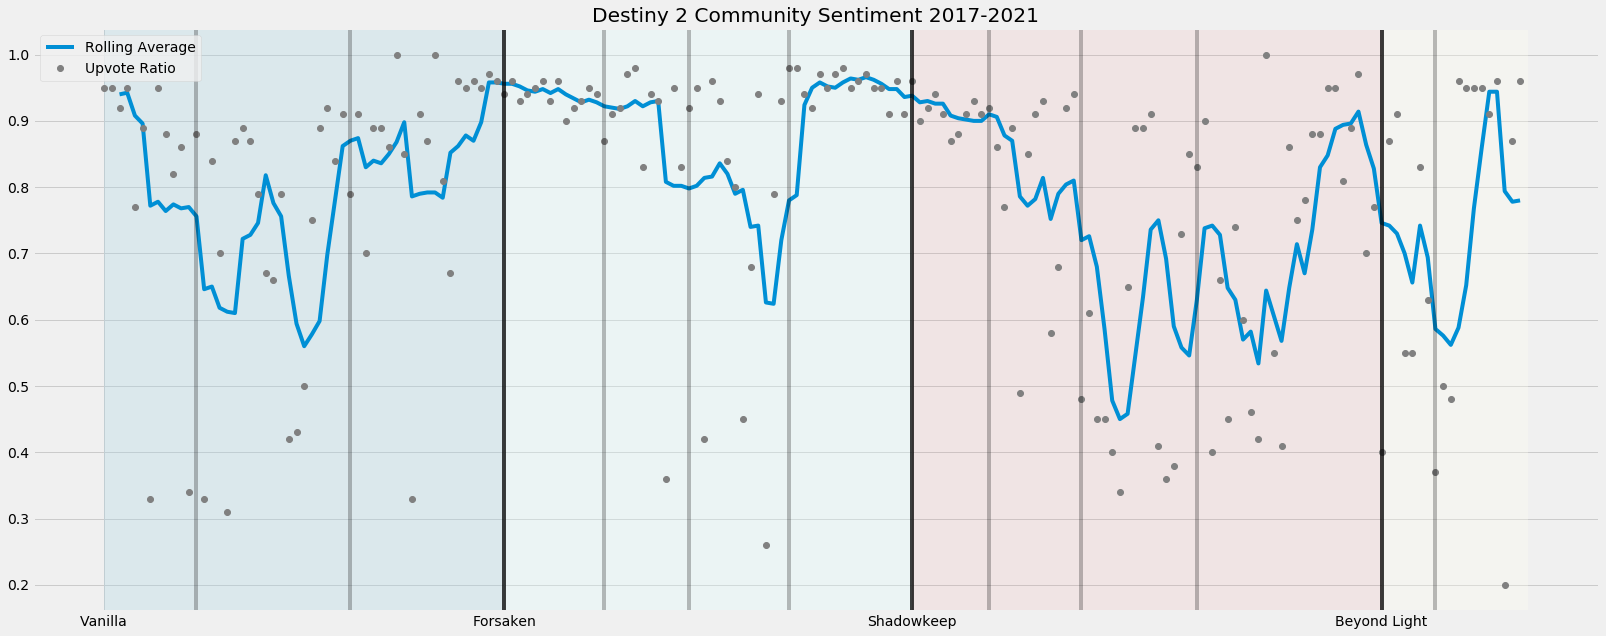

In [92]:
plt.style.use('fivethirtyeight')

width1 = 25
height1 = 10
width_height_1 = (width1, height1)

plt.figure(figsize=width_height_1)
plt.plot(dfSub["5week_rolling_avg"], marker='', label="Rolling Average")
plt.plot(dfSub["UpvoteRatio"], marker='o', color='gray', linewidth=0, label="Upvote Ratio")
plt.title('Destiny 2 Community Sentiment 2017-2021')
# plt.xlabel('Expansion')
# plt.ylabel('Upvote Ratio')
plt.axvspan(0, 52, facecolor='lightblue', alpha=0.3)
plt.axvspan(52, 105, facecolor='lightcyan', alpha=0.3)
plt.axvspan(105, 166, facecolor='lightcoral', alpha=0.1)
plt.axvspan(166, 185, facecolor='ivory', alpha=0.3)

seasons = [12,32,65,76,89,115,127,142,173]
for a in seasons:
    plt.axvline(a, color='black', alpha=0.25)

expansions = [52,105,166]
for a in expansions:
    plt.axvline(a, color='black', alpha=0.75)

# show legend
plt.legend()
plt.xticks((0,52,105,166),("Vanilla","Forsaken","Shadowkeep","Beyond Light"))
plt.show()

[]

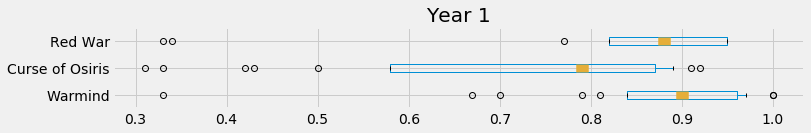

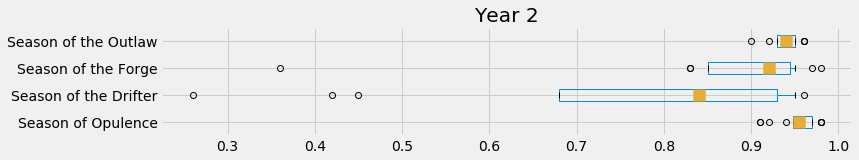

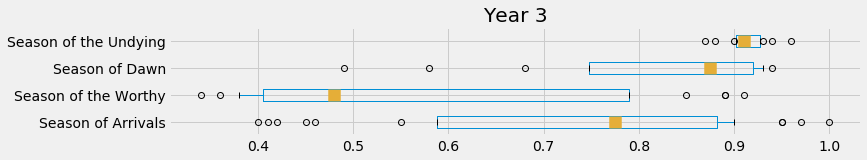

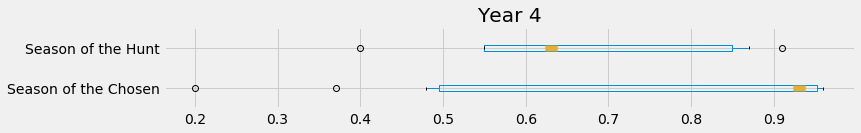

In [93]:
plt.style.use('fivethirtyeight')

df1 = dfSub[dfSub.Expansion == "Vanilla"]
df2 = dfSub[dfSub.Expansion == "Forsaken"]
df3 = dfSub[dfSub.Expansion == "Shadowkeep"]
df4 = dfSub[dfSub.Expansion == "BeyondLight"]

medianprops = dict(linestyle='-.', linewidth=12.5, markerfacecolor='red')

boxplot1 = df1.boxplot(column=['UpvoteRatio'],by="Season", vert=False, figsize=(12,1.5),\
                        whis=0.1,medianprops=medianprops, \
                        positions=[1,2,0]\
                        )
boxplot1.set_title('Year 1')
boxplot1.set_xlabel('')
plt.suptitle('')
boxplot1.plot()

boxplot2 = df2.boxplot(column=['UpvoteRatio'],by="Season", vert=False, figsize=(12,2),\
                        whis=0.1,medianprops=medianprops, \
                        positions=[0,1,2,3]\
                        )    
boxplot2.set_title('Year 2')
boxplot2.set_xlabel('')
plt.suptitle('')
boxplot2.plot()

boxplot3 = df3.boxplot(column=['UpvoteRatio'],by="Season", vert=False, figsize=(12,2),\
                        whis=0.1,medianprops=medianprops, \
                        positions=[1,3,4,2]\
                        )
boxplot3.set_title('Year 3')
boxplot3.set_xlabel('')
plt.suptitle('')
boxplot3.plot()

boxplot4 = df4.boxplot(column=['UpvoteRatio'],by="Season", vert=False, figsize=(12,1.5),\
                        whis=0.1,medianprops=medianprops, \
                        positions=[0,1]\
                        )    
boxplot4.set_title('Year 4')
boxplot4.set_xlabel('')
plt.suptitle('')
boxplot4.plot()

In [103]:
df = dfSub[["Season","UpvoteRatio","Expansion"]]
df = df.groupby(by=["Season","Expansion"]).mean()
df.sort_values(by=['UpvoteRatio'], ascending=False)

dft = df.sort_values(by=['UpvoteRatio'], ascending=False)
display(dft.style.format("{:.0%}"))

df1 = dfSub[["UpvoteRatio","Expansion"]]
df1 = df1.groupby(by=["Expansion"]).mean()
df1 =df1.sort_values(by=['UpvoteRatio'], ascending=False)
df1.style.format("{:.0%}")
display(df1.style.format("{:.0%}"))

,,UpvoteRatio
Season,Expansion,
Season of Opulence,Forsaken,95%
Season of the Outlaw,Forsaken,94%
Season of the Undying,Shadowkeep,91%
Season of the Forge,Forsaken,86%
Warmind,Vanilla,86%
Season of Dawn,Shadowkeep,81%
Red War,Vanilla,81%
Season of the Drifter,Forsaken,76%
Season of the Chosen,BeyondLight,75%


,UpvoteRatio
Expansion,
Forsaken,88%
Vanilla,79%
Shadowkeep,74%
BeyondLight,73%


In [114]:
df = dfSub[["Title","Season","UpvoteRatio","Expansion"]]
display(df.sort_values(by=['UpvoteRatio'], ascending=False).head(10))
display(df.sort_values(by=['UpvoteRatio'], ascending=True).head(10))

,Title,Season,UpvoteRatio,Expansion
151,This Week at Bungie - 8/06/20,Season of Arrivals,1.00,Shadowkeep
43,This Week At Bungie 7/5/2018,Warmind,1.00,Vanilla
38,This Week At Bungie 6/14/2018,Warmind,1.00,Vanilla
96,This Week At Bungie 8/1/2019,Season of Opulence,0.98,Forsaken
90,This Week At Bungie 6/13/2019,Season of Opulence,0.98,Forsaken
89,This Week At Bungie 06/06/2019,Season of Opulence,0.98,Forsaken
69,This Week At Bungie 1/17/2019,Season of the Forge,0.98,Forsaken
99,This Week At Bungie 8/22/2019,Season of Opulence,0.97,Forsaken
68,This Week At Bungie 1/11/2019,Season of the Forge,0.97,Forsaken
93,This Week At Bungie 7/11/2019,Season of Opulence,0.97,Forsaken


,Title,Season,UpvoteRatio,Expansion
182,This Week At Bungie 4/22/2021,Season of the Chosen,0.20,BeyondLight
86,This Week At Bungie 5/16/2019,Season of the Drifter,0.26,Forsaken
16,This Week At Bungie 01/18/2018,Curse of Osiris,0.31,Vanilla
13,This Week At Bungie 12/07/2017,Curse of Osiris,0.33,Vanilla
6,This Week At Bungie 10/19/2017,Red War,0.33,Vanilla
40,This Week at Bungie 6/21/2018,Warmind,0.33,Vanilla
132,This Week At Bungie 4/09/2020,Season of the Worthy,0.34,Shadowkeep
11,This Week at Bungie - 11/22/2017,Red War,0.34,Vanilla
73,This Week At Bungie 2/14/2019,Season of the Forge,0.36,Forsaken
138,This Week At Bungie 5/21/2020,Season of the Worthy,0.36,Shadowkeep
